# Group Classification (ZenML)

Train the group classifier with the updated pipeline structure.

In [1]:
from pathlib import Path
from pioneerml.pipelines.training.group_classification.steps.loader import load_group_classifier_dataset_local

from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import group_classification_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Parquet inputs. Edit this list to point at the files you want to train on.
data_dir = Path(PROJECT_ROOT) / "data"
parquet_paths = sorted(data_dir.glob("ml_output_*.parquet"))

# Example: uncomment to select a smaller subset
parquet_paths = parquet_paths[:1]

parquet_paths = [str(p) for p in parquet_paths]
if not parquet_paths:
    raise RuntimeError(f"No parquet files found in {data_dir}")


In [3]:
# Run the pipeline
run = group_classification_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    pipeline_config={
        "loader": {"config_json": {"time_window_ns": 1.0}},
        "hpo": {"enabled": True, "n_trials": 0, "max_epochs": 1, "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/group_classifier_hpo.db"},
        "train": {"max_epochs": 1},
        "export": {"prefer_cuda": True, "export_dir": str(PROJECT_ROOT / "trained_models" / "groupclassifier")},
    },
)

trained_module = load_step_output(run, "train_group_classifier")
metrics = load_step_output(run, "evaluate_group_classifier")
export = load_step_output(run, "export_group_classifier")

print("metrics:", metrics)
print("export:", export)


Initiating a new run for the pipeline: group_classification_pipeline.
Caching is disabled by default for group_classification_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_group_classifier_dataset has started.
Step load_group_classifier_dataset has finished in 0.744s.
Step tune_group_classifier has started.


[I 2026-02-03 05:49:57,215] Using an existing study with name 'group_classifier_hpo' instead of creating a new one.


Step tune_group_classifier has finished in 0.634s.
Step train_group_classifier has started.
[train_group_classifier] GPU available: True (cuda), used: True
[train_group_classifier] TPU available: False, using: 0 TPU cores
[train_group_classifier] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[train_group_classifier] You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set torch.set_float32_matmul_precision('medium' | 'high') which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[train_group_classifier] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[train_group_classifier] Trainer.fit stopped: max_epochs=1 reached.


[train_group_classifier] No materializer is registered for type <class 'pioneerml.common.training.lightning.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.training.lightning.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_group_classifier has finished in 1m20s.
Step evaluate_group_classifier has started.
Step evaluate_group_classifier has finished in 19.216s.
Step export_group_classifier has started.
Step export_group_classifier has finished in 1.700s.
Pipeline run has finished in 1m47s.
metrics: {'loss': 0.0703828646739722, 'accuracy': 0.9845532774925232, 'exact_match': 0.9599789381027222, 'confusion': [{'tp': 0.9739217652958877, 'fp': 0.009027081243731194, '

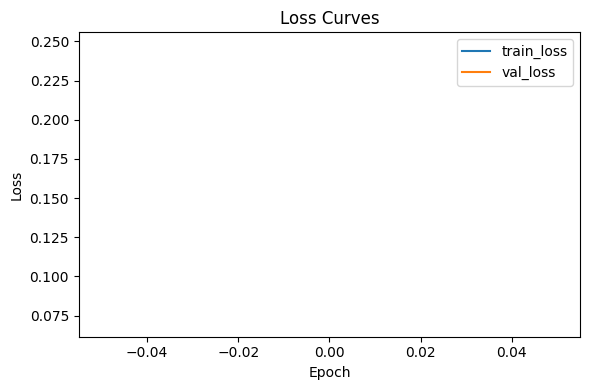

In [4]:
# Plot loss curves
from pioneerml.common.evaluation.plots.loss import LossCurvesPlot

if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")

LossCurvesPlot().render(trained_module, show=True)
